In [98]:
%matplotlib inline
from matplotlib import pyplot as plt

## Build loss function

In [109]:
import json
import os
import sys

import numpy as np
import tensorflow as tf

import tetris_api

ACTIONS = {3: 'up', 2: 'right', 1: 'left', 0: 'down'}

if sys.version_info.major == 2:
    range = xrange

num_cols = 4
num_rows = 16
gamma = 0.8
num_hidden = 50
learning_rate = 1e-2

max_ep = 99999999 # how many steps to take
update_frequency = 10 # after how many games to update model

# create environment
env = tetris_api.PyTetrisEnv()
tf.reset_default_graph()  # clear the Tensorflow graph.

# TODO build graph here
# build nodes
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, num_cols*num_rows])
actions = tf.placeholder(tf.int32, shape=[None])
rewards = tf.placeholder(tf.float32, shape=[None])

# build weights and biases 
W = tf.truncated_normal([num_cols*num_rows,4], stddev=0.001)
b = tf.Variable(tf.zeros([4]))

# regression model
y = tf.matmul(x,W) + b
output = tf.nn.softmax(y)

# get prob for chosen action
action_indices = tf.range(0, tf.shape(y)[0]) * tf.shape(y)[1] + actions
prob_for_picked_actions = tf.gather(tf.reshape(y, [-1]), action_indices)

# loss function
cross_entropy = -tf.reduce_mean(tf.log(prob_for_picked_actions) * rewards)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

sess.run(tf.global_variables_initializer())
# sess.run(output, feed_dict={x:x_in})


import tf_rl_utils
env = tetris_api.PyTetrisEnv()
all_ep_history = []
game_num = 0
game_rewards = []
action_history = []
while True:
    s, _, _, _ = env.reset(number_of_rows=num_rows, number_of_cols=num_cols)
    s = tf_rl_utils.prepro(s)
    prior_state = np.zeros_like(s)
    ep_history = []
    for j in range(max_ep):
        # determine action
        del_state = s - prior_state 
        a_dist = sess.run(output, feed_dict={x: [del_state]})
        picked_action_prob = np.random.choice(a_dist[0], p=a_dist[0])
        action = np.argmax(a_dist == picked_action_prob)
        action_history.append(action)
        
        # take action
        prior_state = s
        s, r, done, _ = env.step(ACTIONS[action]) 
        s = tf_rl_utils.prepro(s)
        
        ep_history.append(np.array([del_state, action, r]))
        if done:
            # game_states = []
            ep_history = np.array(ep_history)
            ep_history[:, 2] = tf_rl_utils.discount_rewards(ep_history[:, 2], gamma=gamma)
            all_ep_history.append(ep_history)
            game_rewards.append(np.sum(ep_history[:, 2]))
            ep_history = []

            its_time_to_update_weights = ((game_num % update_frequency) == 0 and (game_num != 0))
            if its_time_to_update_weights:
                print game_num, np.mean(game_rewards[game_num-10:game_num])
                all_ep_history = np.vstack(all_ep_history)
                feed_dict = {rewards: all_ep_history[:, 2],
                             actions: all_ep_history[:, 1],
                             x: np.vstack(all_ep_history[:, 0])}
                sess.run(train_step, feed_dict=feed_dict)
                all_ep_history = []
            break
    game_num += 1

10 224.999784733


/Users/crawles/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:70: RuntimeWarning: invalid value encountered in less


20 15.0000055108
30 -4.99999387002
40 -4.99999387002
50 -4.99999387002
60 -4.99999387002
70 -4.99999387002
80 -4.99999387002
90 -4.99999387002
100 -4.99999387002
110 -4.99999387002
120 -4.99999387002
130 -4.99999387002
140 -4.99999387002
150 -4.99999387002
160 -4.99999387002
170 -4.99999387002
180 -4.99999387002
190 -4.99999387002
200 -4.99999387002
210 -4.99999387002
220 -4.99999387002
230 -4.99999387002
240 -4.99999387002
250 -4.99999387002
260 -4.99999387002
270 -4.99999387002
280 -4.99999387002
290 -4.99999387002
300 -4.99999387002
310 -4.99999387002
320 -4.99999387002
330 -4.99999387002
340 -4.99999387002
350 -4.99999387002
360 -4.99999387002
370 -4.99999387002
380 -4.99999387002
390 -4.99999387002
400 -4.99999387002
410 -4.99999387002
420 -4.99999387002
430 -4.99999387002
440 -4.99999387002
450 -4.99999387002
460 -4.99999387002
470 -4.99999387002
480 -4.99999387002
490 -4.99999387002
500 -4.99999387002


KeyboardInterrupt: 

(array([ 4337.,     0.,     0.,   411.,     0.,     0.,   413.,     0.,
            0.,   438.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

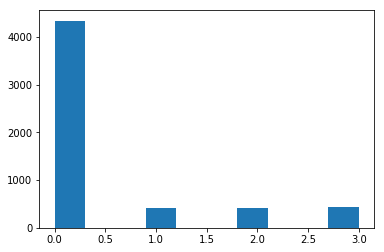

In [108]:
plt.hist(action_history)

In [81]:
s, _, _, _ = env.reset(number_of_rows=num_rows, number_of_cols=num_cols)
s = tf_rl_utils.prepro(s)
prior_state = np.zeros_like(s)
ep_history = []
for j in range(max_ep):
    # determine action
    del_state = s - prior_state 
    a_dist = sess.run(output, feed_dict={x: [del_state]})
    picked_action_prob = np.random.choice(a_dist[0], p=a_dist[0])
    action = np.argmax(a_dist == picked_action_prob)

    # take action
    prior_state = s
    s, r, done, _ = env.step(ACTIONS[action]) 
    s = tf_rl_utils.prepro(s)

    ep_history.append(np.array([del_state, action, r]))
    if done:
        break

ep_history = np.array(ep_history)
print ep_history[:,2].sum()

-1.0


array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [55]:

s, r, done, _ = env.step(ACTIONS[0]) 
import IPython.terminal.ipapp

In [205]:
all_ep_history[:, 0].shape
np.vstack(all_ep_history[:, 0]).shape

(8228, 96)

In [202]:
all_ep_history = np.vstack(all_ep_history)
all_ep_history.shape

(8228, 3)

In [163]:
s, _, _, _ = env.reset(number_of_rows=num_rows, number_of_cols=num_cols)
s = tf_rl_utils.prepro(s)
prior_state = np.zeros_like(s)
del_state = s - prior_state 
del_state

array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

In [9]:
[0,0,1,0], [.3,.01,.5,.19]
1, .5

96

In [66]:
# sess.run(labels)
sess.run(actions)
actions

<tf.Tensor 'Const_28:0' shape=(10,) dtype=int64>

In [105]:
# tf.convert_to_tensor()
actions = []
labels = []
for i in range(10):
    action = np.random.randint(0,4)
#     action = 1
    actions.append(action)
    label = [0,0,0,0]
    label[action] = 1
    labels.append(label)
actions = np.array(actions, dtype=np.int32)
labels = np.array(labels, dtype=np.int32)
# actions = tf.convert_to_tensor(actions)
# labels = tf.convert_to_tensor(labels)
# picked_actions = tf.gather(labels, actions, axis=1)
# sess.run(picked_actions)

In [104]:
sess.run(tf.reshape(labels, [-1]))

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0], dtype=int32)

In [108]:
x = tf.placeholder(tf.float32, shape=[10, num_cols*num_rows])
y_ = tf.placeholder(tf.float32, shape=[10, 4])

indices = tf.range(0, tf.shape(y_)[0]) * tf.shape(y_)[1] + actions
picked_actions = tf.gather(tf.reshape(y_, [-1]), indices)
prob_for_picked_actions = tf.gather(tf.reshape(y_, [-1]), indices)

sess.run(prob_for_picked_actions,feed_dict={y_:labels})

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [107]:
tf

<module 'tensorflow' from '/Users/crawles/anaconda/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

## Appendix
### View loss

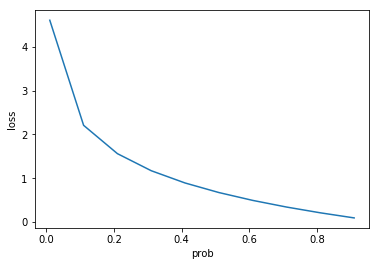

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

probs = np.arange(0.01,1,0.1)
reward = 1
loss = -reward*(np.log(probs))
plt.plot(probs, loss)
plt.ylabel('loss')
plt.xlabel('prob')